In [7]:
# Core utilities moved to fire_model package
import numpy as np
import matplotlib.pyplot as plt
from fire_model.ca import FireEnv, FireState, CAFireModel
from fire_model.boundary import (
    FireBoundary,
    between_boundaries_mask,
    candidates_from_mask,
    extract_fire_boundary,
    plot_fire_boundary,
)
from fire_model.harmonic import (
    HarmonicStripMap,
    BoundaryMap,
    build_harmonic_strip_map_uniform,
    plot_strip_map,
    sd_to_xy_theta,
    build_boundary_map,
    plot_boundary_correspondence,
)
from fire_model.bo import (
    RetardantDropBayesOpt,
    SearchGridProjector,
    TiedXYFiMatern,
    expected_improvement,
)

import fire_model.bo as bo

### Environment Set-Up

In [2]:
# Grid / domain
nx = ny = 120
domain_km = 5

# Time discretisation (used for indexing time-varying wind and for FireState.t)
dt_s = 5.0

# Fire physics parameters
burn_time_s0 = 15 * 60         # how long a cell stays "burning" after ignition (seconds)
ros_mps = 0.2                 # baseline ROS (m/s)

# Retardant parameters
retardant_half_life_s = 2400.0 # seconds (e.g., 40 minutes)
retardant_k = 1.25             # attenuation strength exp(-k * retardant)

# Spatial maps
xs = np.linspace(-1.0, 1.0, nx)[:, None]
ys = np.linspace(-1.0, 1.0, ny)[None, :]
fuel = 0.7 + 0.9 * np.exp(-3.0 * (xs**2 + ys**2))
fuel = np.ones((nx, ny), dtype=float)
value = 1.0 + 3.0 * np.exp(-4.0 * ((xs - 0.2) ** 2 + (ys + 0.1) ** 2))
value = np.ones((nx, ny), dtype=float)

# Constant wind: mild south-westerly
wind=np.zeros((nx, ny, 2), dtype=float)
wind[..., 0] = 0
wind[..., 1] = 15.0  # 5 m/s northwards

env = FireEnv(
    grid_size=(nx, ny),
    domain_km=domain_km,
    wind=wind,
    fuel=fuel,
    value=value,
    dt_s=dt_s,
    burn_time_s0=burn_time_s0,
    retardant_half_life_s=retardant_half_life_s,
    retardant_k=retardant_k,
    ros_mps=ros_mps,
    # wind_coeff is unused by the Finsler model, but can exist in the env
    wind_coeff=0.6,
    ros_future_jitter_frac=0.2,
    wind_coeff_future_jitter_frac=0.2,
    diag=True,
    avoid_burning_drop=True,
    avoid_drop_p_threshold=0.05,
)

ca_model = CAFireModel(env,seed=42)

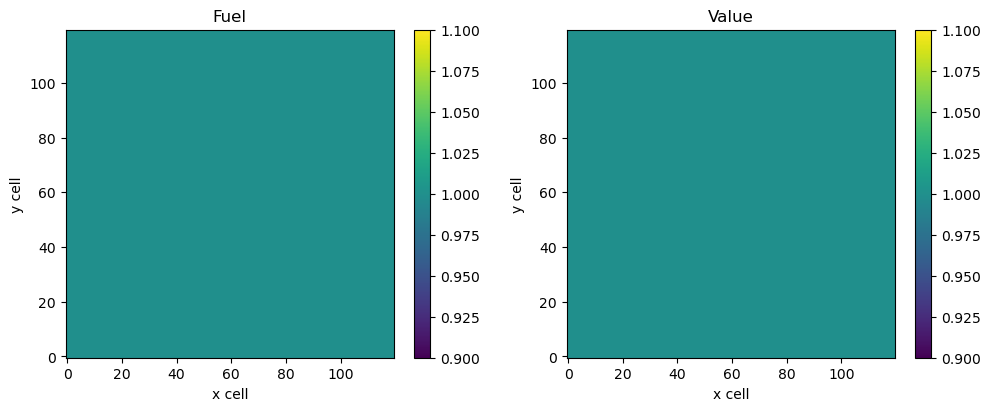

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

im0 = ax[0].imshow(fuel.T, origin="lower", aspect="equal")
ax[0].set_title("Fuel")
ax[0].set_xlabel("x cell"); ax[0].set_ylabel("y cell")
fig.colorbar(im0, ax=ax[0], fraction=0.046)

im1 = ax[1].imshow(value.T, origin="lower", aspect="equal")
ax[1].set_title("Value")
ax[1].set_xlabel("x cell"); ax[1].set_ylabel("y cell")
fig.colorbar(im1, ax=ax[1], fraction=0.046)

plt.show()

### Ignition and Search Domain

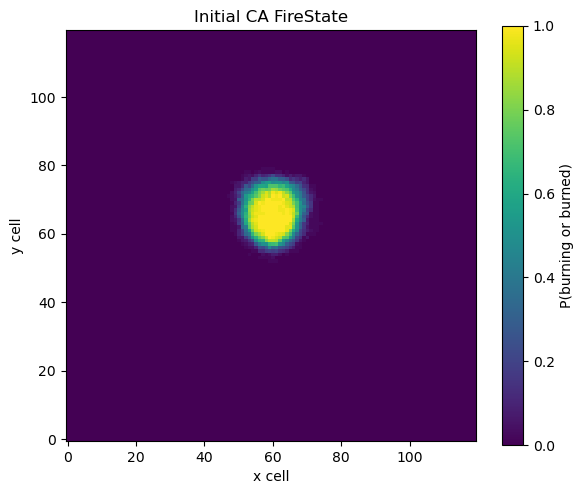

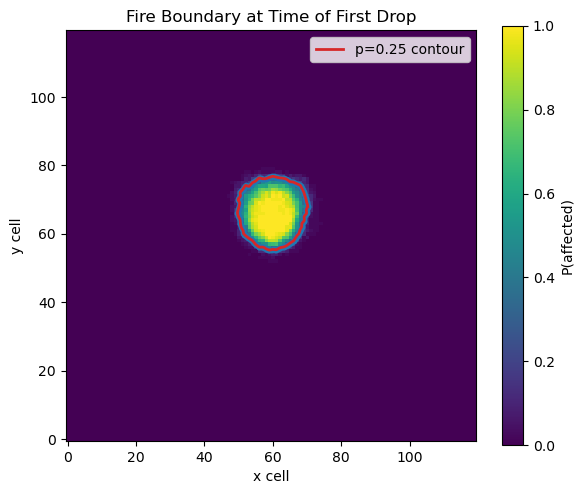

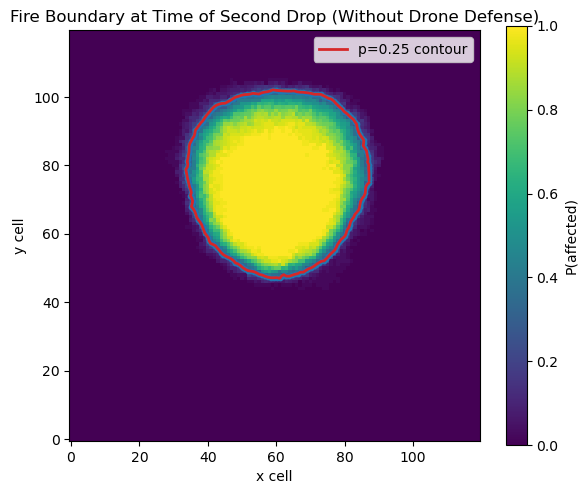

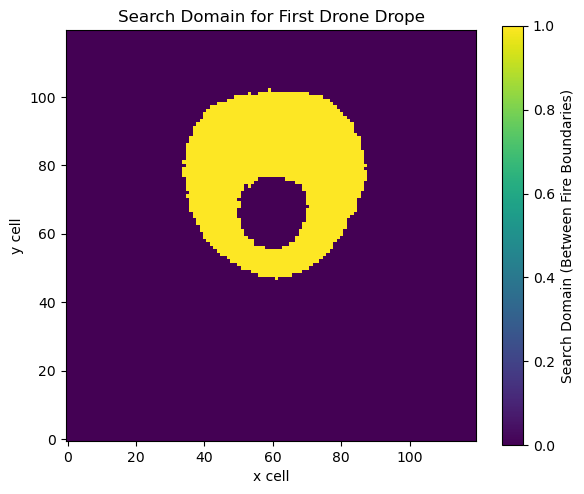

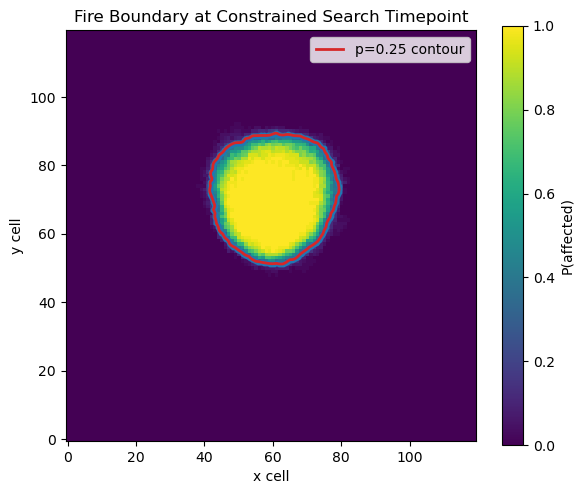

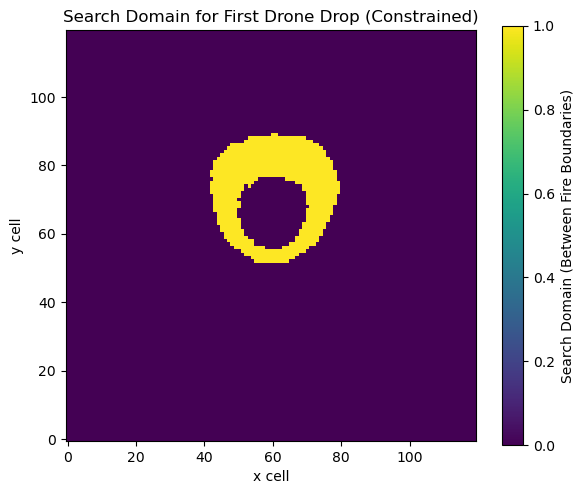

In [8]:
# Ignition and time until drones reach the fire
ignition_center = (nx // 2, ny // 2)
ignition_radius_km = 0.01
time_to_first_drop = 100.0  # 1 minute to response
time_to_second_drop = 240.0 # 2 minutes later 
search_space_time = (time_to_second_drop - time_to_first_drop)//2

# Initial Evolution
init_firestate_ca = ca_model.simulate_from_ignition(
    center=ignition_center,
    radius_km=ignition_radius_km,
    n_sims=50,
    T=time_to_first_drop
)

ca_model.plot_firestate(init_firestate_ca,title="Initial CA FireState")

# Visualising the boundary
init_boundary = extract_fire_boundary(
    init_firestate_ca,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    init_firestate_ca,
    init_boundary,
    field="affected",
    title="Fire Boundary at Time of First Drop"
)

# Visualising the search domain
second_firestate_ca = ca_model.simulate_from_firestate(
    init_firestate=init_firestate_ca,
    T=time_to_second_drop - time_to_first_drop, # assumes we want to search the whole space between first & second drop (smaller might be better in practice)
    n_sims=50,
)

second_boundary = extract_fire_boundary(
    second_firestate_ca,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    second_firestate_ca,
    second_boundary,
    field="affected",
    title="Fire Boundary at Time of Second Drop (Without Drone Defense)"
)

between_boundaries_mask = ca_model.discretise_between_boundaries(init_boundary, second_boundary)

ca_model.plot_search_domain(between_boundaries_mask,title="Search Domain for First Drone Drope")

# Extra constrained search space

constrained_firestate_ca = ca_model.simulate_from_firestate(
    init_firestate=init_firestate_ca,
    T=search_space_time, # assumes we want to search the whole space between first & second drop (smaller might be better in practice)
    n_sims=50,
)

constrained_boundary = extract_fire_boundary(
    constrained_firestate_ca,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    constrained_firestate_ca,
    constrained_boundary,
    field="affected",
    title="Fire Boundary at Constrained Search Timepoint"
)

between_boundaries_mask = ca_model.discretise_between_boundaries(init_boundary, constrained_boundary)

ca_model.plot_search_domain(between_boundaries_mask,title="Search Domain for First Drone Drop (Constrained)")

### Bayesian Optimisation Set-Up

In [5]:
from fire_model.bo import RetardantDropBayesOpt

constrained_search_time = (time_to_second_drop - time_to_first_drop)*2//3

drop_opt = RetardantDropBayesOpt(
    fire_model=ca_model,
    init_firestate=init_firestate_ca,
    n_drones=4,
    evolution_time_s=time_to_second_drop-time_to_first_drop,
    search_grid_evolution_time_s=constrained_search_time,
    n_sims=50,
    fire_boundary_probability=0.25,
)

[Heuristic] Search grid set up with 529 valid cells in grid.


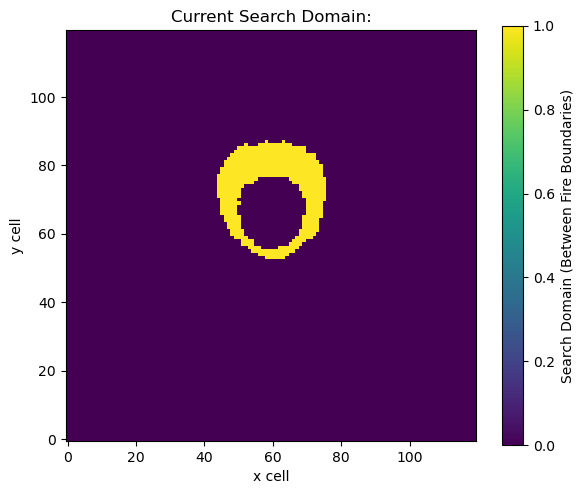

[Heuristic] eval 001/200 | y=1.4117 | best=1.4117
           (x,y,phi) per drone:
           [[53.         58.          2.9069424 ]
 [55.         82.          4.17853681]
 [64.         82.          4.47169581]
 [73.         75.          5.27626303]]
[Heuristic] eval 020/200 | y=1.35694 | best=1.2309
           (x,y,phi) per drone:
           [[46.         70.          4.1698393 ]
 [50.         77.          4.21403519]
 [60.         82.          4.711329  ]
 [67.         79.          5.10780759]]
[Heuristic] eval 040/200 | y=1.26413 | best=1.2309
           (x,y,phi) per drone:
           [[55.         83.          4.46041204]
 [60.         81.          4.91062042]
 [67.         79.          5.12685018]
 [72.         64.          6.02739147]]
[Heuristic] eval 060/200 | y=1.38205 | best=1.2309
           (x,y,phi) per drone:
           [[47.         70.          4.15911148]
 [56.         55.          1.98141761]
 [56.         81.          4.72571364]
 [69.         81.          5.25877971

In [7]:
best_theta, best_params, best_y, (X_feats, y_arr), y_nexts, y_bests_arr =drop_opt.run_heuristic_search(
    n_evals=200,
    heuristic_random_frac=0.0,
    print_every=20,
)

### Heuristic Catalog
Each heuristic maps to `heuristic_modes` inside `sample_heuristic_theta` / `run_heuristic_search`:
- **control_tie_in**: bias drops onto high control-suitability/value arcs near the predicted outer boundary so they reinforce POD/control features.
- **contingency**: place drops farther ahead of the front (deep in the search ring) to act as backup/contingency firelines.
- **point_protection**: find high-value clusters and place retardant on the fire-approach side to shield assets.
- **head_flank**: split drops across wind-aligned head/flank/back segments; orient tangent to the local boundary to slow ROS or lateral spread.
- **confine**: lay short transverse lines to box-in the future footprint using the PCA axes of the final boundary.
- **effective_interaction**: optional filter that keeps only drops expected to intersect the fire soon (pair with another mode, e.g. `["boundary", "effective_interaction"]`).

```python
# BO warm-start with mixed heuristics
best_theta, *_ = drop_opt.run_bayes_opt(
    init_strategy="heuristic",
    init_heuristic_random_frac=0.2,
    init_heuristic_kwargs={
        "heuristic_modes": ["head_flank", "contingency", "effective_interaction"],
        "heuristic_allocations": {"head_flank": 0.5, "contingency": 0.5},
    },
)
```


In [6]:
heuristic_tests = [
    ("head_flank", {"heuristic_modes": ["head_flank"]}),
    ("confine", {"heuristic_modes": ["confine"]}),
    (
        "effective_interaction",
        {"heuristic_modes": ["boundary", "effective_interaction"]},
    ),
    ("control_tie_in", {"heuristic_modes": ["control_tie_in"]}),
    ("contingency", {"heuristic_modes": ["contingency"]}),
    ("point_protection", {"heuristic_modes": ["point_protection"]}),
]
heuristic_results = []
for name, h_kwargs in heuristic_tests:
    print(f"Testing heuristic: {name}")
    best_theta, best_params, best_y, history, y_nexts, y_bests = drop_opt.run_heuristic_search(
        n_evals=60,
        heuristic_random_frac=0.0,
        heuristic_kwargs=h_kwargs,
        verbose=False,
        print_every=20,
    )
    heuristic_results.append(
        {
            "name": name,
            "best_y": best_y,
            "best_params": best_params,
            "theta": best_theta,
        }
    )
    print(f"  best_y={best_y:.6f}")
print("Heuristic summary:")
for entry in heuristic_results:
    print(f"{entry['name']}: best_y={entry['best_y']:.6f}")



Testing heuristic: head_flank


KeyboardInterrupt: 

In [ ]:
print("Testing hybrid heuristic + random mix")
hybrid_heuristic_kwargs = {
    "heuristic_modes": ["control_tie_in", "point_protection", "contingency", "effective_interaction"],
    "heuristic_allocations": {"control_tie_in": 0.4, "point_protection": 0.4, "contingency": 0.2}
}
hybrid_theta, hybrid_params, hybrid_y, hybrid_hist, hybrid_nexts, hybrid_bests = drop_opt.run_heuristic_search(
    n_evals=80,
    heuristic_random_frac=0.25,  # mix in random mask samples
    heuristic_kwargs=hybrid_heuristic_kwargs,
    verbose=False,
)
print(f"Hybrid sweep best_y={hybrid_y:.6f}")
hybrid_theta


Testing hybrid heuristic + random mix
Hybrid sweep best_y=1.221424


array([0.42857143, 0.67226891, 0.90130389, 0.58823529, 0.61344538,
       0.18229362, 0.57142857, 0.68907563, 0.14715661, 0.47058824,
       0.67226891, 0.26752612])

In [ ]:
drop_opt.plot_evolved_firestate(
    theta=best_theta,
    n_sims=50,)

### Bayesian Optimisation (Random Mask Initialisation)

[BO] Search grid set up with 529 valid cells in grid.


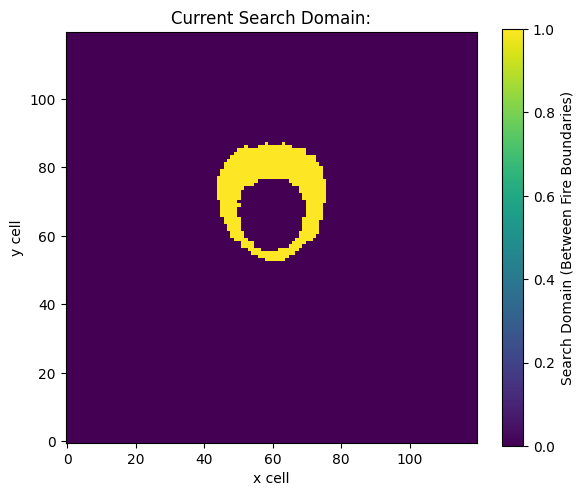

[BO] init: n_init=50, dim=12, n_cells=529
[BO] init: best_y=1.27139, mean_y=1.51143, std_y=0.0954712


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 001/150 | y_next=1.45764 | best_y=1.27139 (no-improve) | EI_max=0.00189 | mu=1.39429 | std=0.0827
      proposed (x,y,phi) per drone:
      [[44.         77.          1.45664784]
 [52.         86.          0.11658977]
 [63.         87.          5.00183973]
 [72.         83.          0.60185931]]
      gp.kernel_ = 1.02**2 * TiedXYFiMatern(lx=0.105, ly=0.127, lphi=2.29, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 010/150 | y_next=1.5126 | best_y=1.27139 (no-improve) | EI_max=0.000303 | mu=1.44942 | std=0.0819
      proposed (x,y,phi) per drone:
      [[47.         82.          0.26785557]
 [49.         84.          5.51026771]
 [63.         77.          3.34353576]
 [69.         85.          1.31936371]]
      gp.kernel_ = 0.713**2 * TiedXYFiMatern(lx=0.0992, ly=0.139, lphi=2.97, nu=2.5) + WhiteKernel(noise_level=0.488)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 020/150 | y_next=1.43128 | best_y=1.27139 (no-improve) | EI_max=0.000182 | mu=1.44201 | std=0.0742
      proposed (x,y,phi) per drone:
      [[44.         71.          3.45900075]
 [52.         86.          4.99754427]
 [58.         87.          4.24715124]
 [75.         76.          6.04666898]]
      gp.kernel_ = 0.671**2 * TiedXYFiMatern(lx=0.116, ly=0.122, lphi=4.16, nu=2.5) + WhiteKernel(noise_level=0.555)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packa

[BO] iter 030/150 | y_next=1.50375 | best_y=1.27139 (no-improve) | EI_max=0.000171 | mu=1.4477 | std=0.0757
      proposed (x,y,phi) per drone:
      [[44.         71.          4.4399043 ]
 [52.         86.          5.5221026 ]
 [74.         80.          1.93206127]
 [74.         80.          4.08027829]]
      gp.kernel_ = 0.709**2 * TiedXYFiMatern(lx=0.162, ly=0.168, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.603)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 040/150 | y_next=1.44472 | best_y=1.27139 (no-improve) | EI_max=0.000139 | mu=1.44675 | std=0.0736
      proposed (x,y,phi) per drone:
      [[44.         77.          6.16389276]
 [46.         81.          5.4665227 ]
 [63.         87.          4.27200144]
 [75.         76.          0.78245138]]
      gp.kernel_ = 0.676**2 * TiedXYFiMatern(lx=0.188, ly=0.21, lphi=923, nu=2.5) + WhiteKernel(noise_level=0.684)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 050/150 | y_next=1.39969 | best_y=1.27139 (no-improve) | EI_max=9.24e-05 | mu=1.44587 | std=0.0701
      proposed (x,y,phi) per drone:
      [[44.         77.          2.76389718]
 [52.         86.          4.2212098 ]
 [58.         79.          1.20116946]
 [72.         83.          1.33137101]]
      gp.kernel_ = 0.748**2 * TiedXYFiMatern(lx=0.195, ly=0.212, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.652)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 060/150 | y_next=1.4559 | best_y=1.27139 (no-improve) | EI_max=0.000114 | mu=1.44078 | std=0.0699
      proposed (x,y,phi) per drone:
      [[45.         66.          0.41276063]
 [50.         85.          1.79473077]
 [69.         85.          3.91334938]
 [75.         76.          0.48423514]]
      gp.kernel_ = 0.748**2 * TiedXYFiMatern(lx=0.185, ly=0.22, lphi=22.6, nu=2.5) + WhiteKernel(noise_level=0.643)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 070/150 | y_next=1.41715 | best_y=1.27139 (no-improve) | EI_max=7.05e-05 | mu=1.44497 | std=0.0678
      proposed (x,y,phi) per drone:
      [[44.         76.          4.22071104]
 [49.         84.          2.3036825 ]
 [58.         85.          5.36970539]
 [75.         76.          3.93614458]]
      gp.kernel_ = 0.778**2 * TiedXYFiMatern(lx=0.214, ly=0.239, lphi=54.3, nu=2.5) + WhiteKernel(noise_level=0.668)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 080/150 | y_next=1.39042 | best_y=1.27139 (no-improve) | EI_max=5.59e-05 | mu=1.44789 | std=0.0672
      proposed (x,y,phi) per drone:
      [[44.         71.          2.74132766]
 [50.         85.          1.99981557]
 [52.         78.          5.42012543]
 [74.         80.          3.85740699]]
      gp.kernel_ = 0.828**2 * TiedXYFiMatern(lx=0.241, ly=0.25, lphi=33.8, nu=2.5) + WhiteKernel(noise_level=0.634)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 090/150 | y_next=1.5499 | best_y=1.27139 (no-improve) | EI_max=7.44e-05 | mu=1.43481 | std=0.0648
      proposed (x,y,phi) per drone:
      [[44.         71.          4.95200841]
 [50.         85.          0.7391493 ]
 [54.         78.          0.65782091]
 [74.         80.          3.07212745]]
      gp.kernel_ = 0.874**2 * TiedXYFiMatern(lx=0.27, ly=0.253, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.633)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 100/150 | y_next=1.47274 | best_y=1.27139 (no-improve) | EI_max=5.71e-05 | mu=1.44274 | std=0.0657
      proposed (x,y,phi) per drone:
      [[4.40000000e+01 7.10000000e+01 1.65258579e+00]
 [5.20000000e+01 8.40000000e+01 4.00398270e+00]
 [6.00000000e+01 8.30000000e+01 3.33762723e-01]
 [7.20000000e+01 8.30000000e+01 7.12680965e-02]]
      gp.kernel_ = 0.896**2 * TiedXYFiMatern(lx=0.3, ly=0.284, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.656)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 110/150 | y_next=1.45226 | best_y=1.27139 (no-improve) | EI_max=6.14e-05 | mu=1.43949 | std=0.0651
      proposed (x,y,phi) per drone:
      [[45.         77.          1.01806094]
 [52.         86.          4.47494196]
 [58.         77.          1.47220737]
 [72.         83.          2.38795114]]
      gp.kernel_ = 0.914**2 * TiedXYFiMatern(lx=0.284, ly=0.27, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.651)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 120/150 | y_next=1.46806 | best_y=1.27139 (no-improve) | EI_max=3.27e-05 | mu=1.44834 | std=0.0641
      proposed (x,y,phi) per drone:
      [[46.         81.          5.90698624]
 [56.         86.          5.64393837]
 [60.         79.          3.4593636 ]
 [74.         80.          5.96516345]]
      gp.kernel_ = 0.958**2 * TiedXYFiMatern(lx=0.304, ly=0.279, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.654)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 130/150 | y_next=1.3784 | best_y=1.27139 (no-improve) | EI_max=3.84e-05 | mu=1.44129 | std=0.0628
      proposed (x,y,phi) per drone:
      [[45.         66.          0.69361443]
 [52.         86.          4.95412922]
 [58.         80.          1.46666007]
 [74.         80.          0.44622404]]
      gp.kernel_ = 0.988**2 * TiedXYFiMatern(lx=0.316, ly=0.282, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.654)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 140/150 | y_next=1.51337 | best_y=1.27139 (no-improve) | EI_max=3.12e-05 | mu=1.44299 | std=0.0621
      proposed (x,y,phi) per drone:
      [[44.         71.          1.16680997]
 [52.         86.          1.9005664 ]
 [54.         75.          4.39402257]
 [72.         83.          0.86674411]]
      gp.kernel_ = 0.994**2 * TiedXYFiMatern(lx=0.279, ly=0.264, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.648)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 150/150 | y_next=1.48306 | best_y=1.27139 (no-improve) | EI_max=2.25e-05 | mu=1.4487 | std=0.0621
      proposed (x,y,phi) per drone:
      [[44.         71.          4.60279293]
 [58.         87.          3.12790745]
 [66.         75.          0.74712113]
 [72.         83.          5.35016539]]
      gp.kernel_ = 1.01**2 * TiedXYFiMatern(lx=0.289, ly=0.283, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.665)
[BO] done: best_y=1.27139
[BO] best params:
[[4.80000000e+01 7.70000000e+01 5.27062402e+00]
 [6.50000000e+01 8.30000000e+01 1.77160544e+00]
 [7.00000000e+01 5.90000000e+01 2.73728309e+00]
 [7.00000000e+01 6.60000000e+01 2.14600399e-03]]


In [6]:
best_theta, best_params, best_value, (X, y), y_nexts, y_bests = drop_opt.run_bayes_opt(
    n_init=50,
    n_iters=150,
    n_candidates=2**12,
    xi=0.01, 
    verbose=True,
    init_strategy="random_mask",
    candidate_strategy="qmc",
    candidate_qmc="sobol",
    print_every=10,
)

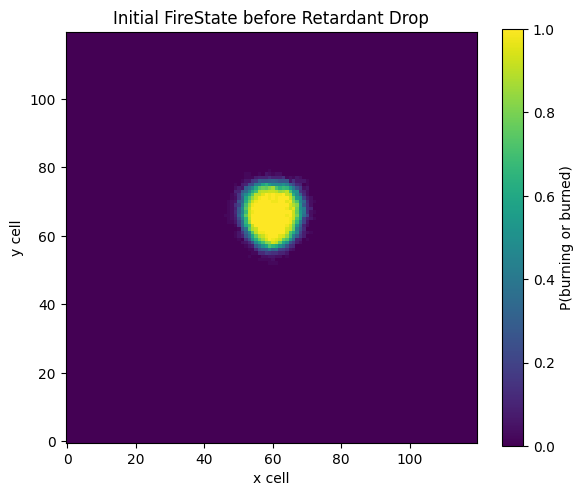

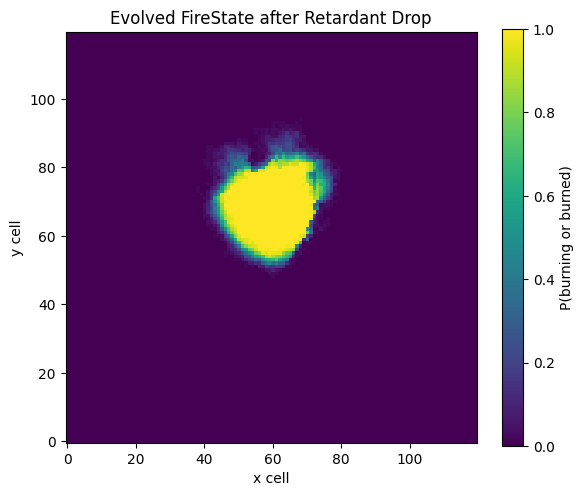

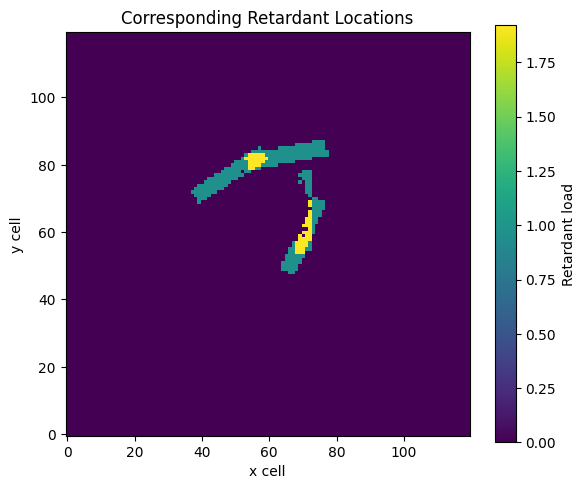

In [7]:
drop_opt.plot_evolved_firestate(
    theta=best_theta,
    n_sims=50,)

### Bayesian Optimisation (Heuristic + Random Initialisation)

In [8]:
search_mask, coords = drop_opt.setup_search_grid(K=300, boundary_field="affected")
best_theta, best_params, best_value, (X, y), y_nexts, y_bests = drop_opt.run_bayes_opt(
    n_init=50,
    n_iters=150,
    n_candidates=2**12,
    xi=0.01, 
    verbose=True,
    init_strategy="heuristic",
    init_heuristic_random_frac=0.3, #% of initial points that are random (the rest are heuristic initialised)
    print_every=10,
    candidate_strategy="qmc",
    candidate_qmc="sobol",
)

[BO] init: n_init=50, dim=12, n_cells=529
[BO] init: best_y=1.2108, mean_y=1.378, std_y=0.120812
[BO] iter 001/150 | y_next=1.44097 | best_y=1.2108 (no-improve) | EI_max=0.013 | mu=1.27925 | std=0.102
      proposed (x,y,phi) per drone:
      [[44.         71.          3.18193089]
 [52.         86.          5.77577472]
 [74.         80.          4.44809828]
 [75.         70.          5.10041437]]
      gp.kernel_ = 1.12**2 * TiedXYFiMatern(lx=597, ly=0.144, lphi=1.61, nu=2.5) + WhiteKernel(noise_level=0.0498)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 010/150 | y_next=1.61878 | best_y=1.2108 (no-improve) | EI_max=0.00662 | mu=1.35735 | std=0.127
      proposed (x,y,phi) per drone:
      [[63.         53.          3.24328328]
 [72.         83.          4.07519707]
 [74.         80.          5.36743013]
 [75.         71.          0.13042823]]
      gp.kernel_ = 1.08**2 * TiedXYFiMatern(lx=0.186, ly=0.156, lphi=1.29, nu=2.5) + WhiteKernel(noise_level=0.0247)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/si

[BO] iter 020/150 | y_next=1.51941 | best_y=1.2108 (no-improve) | EI_max=0.00834 | mu=1.33549 | std=0.122
      proposed (x,y,phi) per drone:
      [[45.         66.          1.59751686]
 [62.         77.          1.56068446]
 [65.         78.          2.65722177]
 [72.         83.          4.60561333]]
      gp.kernel_ = 1.06**2 * TiedXYFiMatern(lx=0.0886, ly=0.0735, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/si

[BO] iter 030/150 | y_next=1.50601 | best_y=1.2108 (no-improve) | EI_max=0.0021 | mu=1.40088 | std=0.117
      proposed (x,y,phi) per drone:
      [[51.         57.          2.78923474]
 [51.         82.          4.22972578]
 [72.         83.          5.71751667]
 [75.         70.          0.2274557 ]]
      gp.kernel_ = 0.985**2 * TiedXYFiMatern(lx=0.0856, ly=0.114, lphi=1.22, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/si

[BO] iter 040/150 | y_next=1.43045 | best_y=1.2108 (no-improve) | EI_max=0.00175 | mu=1.3959 | std=0.111
      proposed (x,y,phi) per drone:
      [[45.         66.          3.11358461]
 [45.         79.          5.14937268]
 [52.         86.          4.42418551]
 [68.         84.          6.20554419]]
      gp.kernel_ = 0.953**2 * TiedXYFiMatern(lx=12.2, ly=0.0695, lphi=0.953, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/si

[BO] iter 050/150 | y_next=1.45997 | best_y=1.2108 (no-improve) | EI_max=0.00126 | mu=1.39539 | std=0.104
      proposed (x,y,phi) per drone:
      [[45.         66.          3.80431996]
 [49.         79.          4.31618833]
 [50.         85.          4.76347956]
 [75.         70.          0.10020805]]
      gp.kernel_ = 0.93**2 * TiedXYFiMatern(lx=0.0952, ly=0.0764, lphi=0.979, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/si

[BO] iter 060/150 | y_next=1.46753 | best_y=1.2108 (no-improve) | EI_max=0.000758 | mu=1.4226 | std=0.107
      proposed (x,y,phi) per drone:
      [[47.         82.          0.14850963]
 [58.         77.          6.04024903]
 [69.         85.          0.14726846]
 [75.         74.          4.09843054]]
      gp.kernel_ = 0.944**2 * TiedXYFiMatern(lx=0.0834, ly=0.0663, lphi=1.43, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/si

[BO] iter 070/150 | y_next=1.59622 | best_y=1.2108 (no-improve) | EI_max=0.000549 | mu=1.43547 | std=0.107
      proposed (x,y,phi) per drone:
      [[49.         84.          4.27650273]
 [54.         55.          0.84745472]
 [55.         76.          1.04003936]
 [63.         53.          0.98617895]]
      gp.kernel_ = 0.954**2 * TiedXYFiMatern(lx=0.0852, ly=0.0632, lphi=1.66, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/si

[BO] iter 080/150 | y_next=1.52816 | best_y=1.2108 (no-improve) | EI_max=0.000251 | mu=1.46628 | std=0.108
      proposed (x,y,phi) per drone:
      [[52.         86.          2.74894327]
 [54.         75.          5.84972741]
 [58.         87.          2.27847606]
 [58.         87.          4.63802748]]
      gp.kernel_ = 1.9**2 * TiedXYFiMatern(lx=0.314, ly=0.362, lphi=12.1, nu=2.5) + WhiteKernel(noise_level=0.34)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/si

[BO] iter 090/150 | y_next=1.49972 | best_y=1.2108 (no-improve) | EI_max=0.000873 | mu=1.39497 | std=0.098
      proposed (x,y,phi) per drone:
      [[48.         60.          3.67931062]
 [57.         81.          5.51781358]
 [58.         84.          5.9923765 ]
 [75.         76.          5.66271549]]
      gp.kernel_ = 0.944**2 * TiedXYFiMatern(lx=0.083, ly=0.0714, lphi=1.35, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/si

[BO] iter 100/150 | y_next=1.37694 | best_y=1.2108 (no-improve) | EI_max=0.000283 | mu=1.39392 | std=0.0831
      proposed (x,y,phi) per drone:
      [[50.         85.          3.57899694]
 [60.         79.          5.09132416]
 [63.         87.          5.52796211]
 [72.         83.          0.09394155]]
      gp.kernel_ = 1.6**2 * TiedXYFiMatern(lx=0.264, ly=0.346, lphi=9.74, nu=2.5) + WhiteKernel(noise_level=0.404)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 110/150 | y_next=1.6008 | best_y=1.2108 (no-improve) | EI_max=0.000115 | mu=1.46711 | std=0.0996
      proposed (x,y,phi) per drone:
      [[52.         86.          3.42891834]
 [63.         53.          5.99249422]
 [69.         85.          5.36152524]
 [72.         60.          5.07496765]]
      gp.kernel_ = 1.59**2 * TiedXYFiMatern(lx=0.259, ly=0.332, lphi=8.23, nu=2.5) + WhiteKernel(noise_level=0.384)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 120/150 | y_next=1.47354 | best_y=1.2108 (no-improve) | EI_max=0.000107 | mu=1.45354 | std=0.0943
      proposed (x,y,phi) per drone:
      [[44.         77.          2.77559294]
 [58.         87.          5.18858807]
 [61.         53.          4.16581141]
 [69.         85.          3.98888356]]
      gp.kernel_ = 1.45**2 * TiedXYFiMatern(lx=0.237, ly=0.296, lphi=6.96, nu=2.5) + WhiteKernel(noise_level=0.372)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 130/150 | y_next=1.62094 | best_y=1.2108 (no-improve) | EI_max=0.000647 | mu=1.41258 | std=0.101
      proposed (x,y,phi) per drone:
      [[57.         77.          6.2796452 ]
 [67.         77.          5.49628927]
 [73.         61.          4.46069712]
 [74.         65.          5.78154557]]
      gp.kernel_ = 1.03**2 * TiedXYFiMatern(lx=0.104, ly=0.0731, lphi=2.31, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 140/150 | y_next=1.50625 | best_y=1.2108 (no-improve) | EI_max=0.000119 | mu=1.43995 | std=0.0908
      proposed (x,y,phi) per drone:
      [[47.         82.          4.24868423]
 [61.         77.          5.68844522]
 [62.         56.          4.33567021]
 [64.         86.          3.94426756]]
      gp.kernel_ = 1.29**2 * TiedXYFiMatern(lx=0.226, ly=0.273, lphi=5.26, nu=2.5) + WhiteKernel(noise_level=0.391)
[BO] iter 150/150 | y_next=1.51226 | best_y=1.2108 (no-improve) | EI_max=4.32e-05 | mu=1.43869 | std=0.0818
      proposed (x,y,phi) per drone:
      [[47

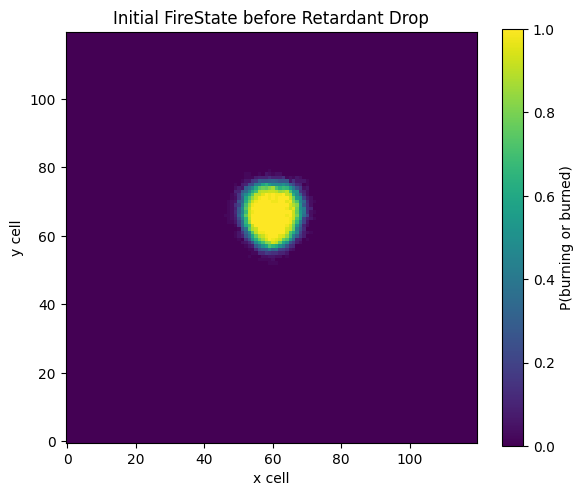

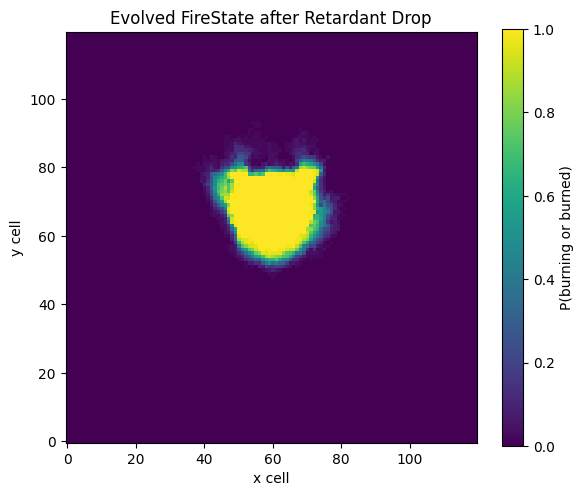

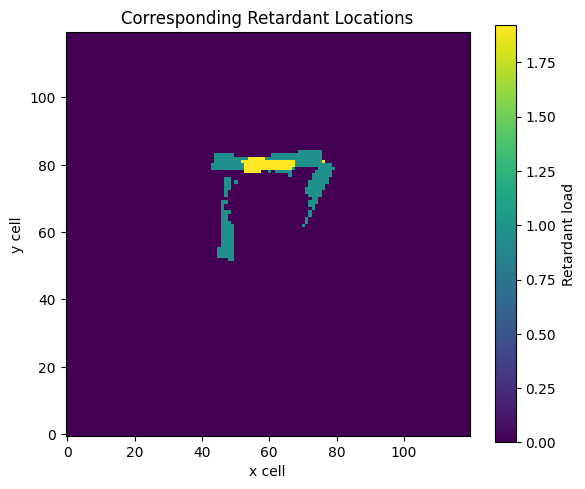

In [9]:
drop_opt.plot_evolved_firestate(
    theta=best_theta,
    n_sims=50,)

### Heuristic + Local Exploitation

In [10]:
search_mask, coords = drop_opt.setup_search_grid(K=300, boundary_field="affected")
best_theta, best_params, best_value, (X, y), y_nexts, y_bests = drop_opt.run_bayes_opt(
    n_init=50,
    n_iters=150,
    n_candidates=2**12, #note will still hit the Sobol balance property warning since Sobol used for global (so n_candidates*(1-candidate_local_frac) should be power of 2)
    xi=0.01, 
    verbose=True,
    init_strategy="heuristic",
    init_heuristic_random_frac=0.3, #% of initial points that are random (the rest are heuristic initialised)
    print_every=10,
    candidate_strategy="mixed",
    candidate_qmc="sobol",
    candidate_local_frac=0.6,
    candidate_local_top_k=5,
    candidate_local_sigma_cells=4.0,
    candidate_local_sigma_phi_rad=np.deg2rad(20),
    init_heuristic_kwargs=hybrid_heuristic_kwargs,
)


[BO] init: n_init=50, dim=12, n_cells=529
[BO] init: best_y=1.30101, mean_y=1.47911, std_y=0.0889441


/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


[BO] iter 001/150 | y_next=1.32913 | best_y=1.30101 (no-improve) | EI_max=0.00701 | mu=1.34391 | std=0.0628
      proposed (x,y,phi) per drone:
      [[48.         83.          2.39249409]
 [50.         69.          6.19159754]
 [63.         77.          4.35931222]
 [67.         82.          1.18191148]]
      gp.kernel_ = 0.974**2 * TiedXYFiMatern(lx=0.0849, ly=846, lphi=1.24, nu=2.5) + WhiteKernel(noise_level=0.0436)


/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.ra

[BO] iter 010/150 | y_next=1.37708 | best_y=1.24219 (no-improve) | EI_max=0.0008 | mu=1.36728 | std=0.0713
      proposed (x,y,phi) per drone:
      [[52.         86.          1.79631953]
 [55.         83.          0.5086228 ]
 [63.         83.          4.20808956]
 [66.         80.          0.91794096]]
      gp.kernel_ = 0.809**2 * TiedXYFiMatern(lx=0.0837, ly=114, lphi=1.34, nu=2.5) + WhiteKernel(noise_level=0.184)


/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.ra

[BO] iter 020/150 | y_next=1.37667 | best_y=1.18108 (no-improve) | EI_max=0.000401 | mu=1.29525 | std=0.0596
      proposed (x,y,phi) per drone:
      [[49.         84.          1.55947377]
 [50.         69.          1.07188752]
 [59.         86.          4.33195404]
 [72.         77.          0.92217753]]
      gp.kernel_ = 0.779**2 * TiedXYFiMatern(lx=0.0946, ly=0.134, lphi=1.5, nu=2.5) + WhiteKernel(noise_level=0.0896)


/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.ra

[BO] iter 030/150 | y_next=1.19368 | best_y=1.18108 (no-improve) | EI_max=0.000269 | mu=1.26755 | std=0.0453
      proposed (x,y,phi) per drone:
      [[48.         77.          1.61753794]
 [49.         59.          0.4057399 ]
 [63.         80.          4.55008509]
 [70.         77.          0.66595757]]
      gp.kernel_ = 0.813**2 * TiedXYFiMatern(lx=0.115, ly=0.1, lphi=1.56, nu=2.5) + WhiteKernel(noise_level=0.0554)


/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.ra

[BO] iter 040/150 | y_next=1.28694 | best_y=1.18108 (no-improve) | EI_max=0.000991 | mu=1.24476 | std=0.0453
      proposed (x,y,phi) per drone:
      [[45.         79.          1.54271891]
 [48.         63.          0.68101982]
 [66.         83.          4.36472318]
 [72.         76.          0.68893788]]
      gp.kernel_ = 0.815**2 * TiedXYFiMatern(lx=0.122, ly=0.109, lphi=1.47, nu=2.5) + WhiteKernel(noise_level=0.064)


/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.ra

[BO] iter 050/150 | y_next=1.46924 | best_y=1.18108 (no-improve) | EI_max=0.000637 | mu=1.40274 | std=0.109
      proposed (x,y,phi) per drone:
      [[50.         85.          4.07474846]
 [58.         87.          5.02437248]
 [69.         85.          3.91737961]
 [72.         60.          3.22565396]]
      gp.kernel_ = 0.881**2 * TiedXYFiMatern(lx=0.138, ly=0.125, lphi=1.71, nu=2.5) + WhiteKernel(noise_level=0.0482)


/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.ra

[BO] iter 060/150 | y_next=1.79628 | best_y=1.18108 (no-improve) | EI_max=0.000498 | mu=1.44885 | std=0.123
      proposed (x,y,phi) per drone:
      [[58.         53.          2.12791827]
 [58.         53.          4.01008596]
 [58.         53.          5.30605173]
 [63.         53.          1.423773  ]]
      gp.kernel_ = 0.922**2 * TiedXYFiMatern(lx=0.152, ly=0.138, lphi=1.78, nu=2.5) + WhiteKernel(noise_level=0.0411)


/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.ra

[BO] iter 070/150 | y_next=1.60337 | best_y=1.16826 (no-improve) | EI_max=0.000372 | mu=1.46269 | std=0.128
      proposed (x,y,phi) per drone:
      [[58.         87.          0.28359374]
 [63.         53.          5.65120218]
 [72.         83.          2.31383363]
 [73.         61.          5.77648408]]
      gp.kernel_ = 0.965**2 * TiedXYFiMatern(lx=0.153, ly=0.155, lphi=2.2, nu=2.5) + WhiteKernel(noise_level=0.0398)


/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.ra

[BO] iter 080/150 | y_next=1.23385 | best_y=1.16826 (no-improve) | EI_max=0.000292 | mu=1.24267 | std=0.0409
      proposed (x,y,phi) per drone:
      [[49.         80.          1.71047986]
 [50.         64.          6.25213274]
 [66.         78.          4.65777154]
 [70.         77.          0.65917052]]
      gp.kernel_ = 0.967**2 * TiedXYFiMatern(lx=0.157, ly=0.164, lphi=2.4, nu=2.5) + WhiteKernel(noise_level=0.0419)


/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.ra

[BO] iter 090/150 | y_next=1.47597 | best_y=1.16826 (no-improve) | EI_max=0.000364 | mu=1.41507 | std=0.11
      proposed (x,y,phi) per drone:
      [[48.         83.          4.7614819 ]
 [52.         86.          5.60889898]
 [73.         61.          3.0956253 ]
 [74.         80.          3.40496065]]
      gp.kernel_ = 0.955**2 * TiedXYFiMatern(lx=0.155, ly=0.154, lphi=2.34, nu=2.5) + WhiteKernel(noise_level=0.0276)


/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.ra

[BO] iter 100/150 | y_next=1.5376 | best_y=1.16826 (no-improve) | EI_max=0.000302 | mu=1.48669 | std=0.133
      proposed (x,y,phi) per drone:
      [[45.         66.          2.50333628]
 [50.         85.          3.98128853]
 [57.         86.          5.02892073]
 [63.         53.          5.30882714]]
      gp.kernel_ = 0.96**2 * TiedXYFiMatern(lx=0.153, ly=0.153, lphi=2.49, nu=2.5) + WhiteKernel(noise_level=0.022)


/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.ra

[BO] iter 110/150 | y_next=1.2859 | best_y=1.16826 (no-improve) | EI_max=0.000551 | mu=1.24406 | std=0.0459
      proposed (x,y,phi) per drone:
      [[52.         76.          2.44774027]
 [54.         58.          0.7585802 ]
 [66.         78.          4.76631631]
 [71.         77.          0.96633329]]
      gp.kernel_ = 0.986**2 * TiedXYFiMatern(lx=0.148, ly=0.159, lphi=3.03, nu=2.5) + WhiteKernel(noise_level=0.0217)


/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.ra

[BO] iter 120/150 | y_next=1.4959 | best_y=1.11924 (no-improve) | EI_max=5.47e-05 | mu=1.45484 | std=0.117
      proposed (x,y,phi) per drone:
      [[51.         57.          1.75276356]
 [58.         87.          4.26800761]
 [58.         87.          6.15242057]
 [75.         70.          3.51706566]]
      gp.kernel_ = 0.972**2 * TiedXYFiMatern(lx=0.146, ly=0.167, lphi=3.12, nu=2.5) + WhiteKernel(noise_level=0.0273)


/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.ra

[BO] iter 130/150 | y_next=1.46667 | best_y=1.11924 (no-improve) | EI_max=3.54e-05 | mu=1.40457 | std=0.0979
      proposed (x,y,phi) per drone:
      [[49.         70.          2.83914115]
 [61.         77.          2.35803548]
 [62.         85.          4.79397364]
 [69.         85.          1.23643753]]
      gp.kernel_ = 0.971**2 * TiedXYFiMatern(lx=0.15, ly=0.177, lphi=3.74, nu=2.5) + WhiteKernel(noise_level=0.033)


/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.ra

[BO] iter 140/150 | y_next=1.53576 | best_y=1.11924 (no-improve) | EI_max=1.99e-05 | mu=1.40961 | std=0.0949
      proposed (x,y,phi) per drone:
      [[4.80000000e+01 7.40000000e+01 4.39407701e+00]
 [6.20000000e+01 7.70000000e+01 4.05871005e+00]
 [6.40000000e+01 7.90000000e+01 3.55532428e-01]
 [6.90000000e+01 6.50000000e+01 4.24002391e-02]]
      gp.kernel_ = 0.973**2 * TiedXYFiMatern(lx=0.148, ly=0.181, lphi=3.73, nu=2.5) + WhiteKernel(noise_level=0.0343)


/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/urasm4pro/Documents/PyroFinsler/fire_model/bo.py:278: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.ra

[BO] iter 150/150 | y_next=1.18684 | best_y=1.11924 (no-improve) | EI_max=1.76e-05 | mu=1.21689 | std=0.0367
      proposed (x,y,phi) per drone:
      [[47.         77.          2.1537516 ]
 [50.         65.          0.35377781]
 [64.         80.          4.7208875 ]
 [70.         75.          1.18273443]]
      gp.kernel_ = 0.963**2 * TiedXYFiMatern(lx=0.148, ly=0.177, lphi=3.79, nu=2.5) + WhiteKernel(noise_level=0.0347)
[BO] done: best_y=1.11924
[BO] best params:
[[50.         77.          1.78416736]
 [51.         61.          0.58415894]
 [62.         80.          4.60723979]
 [70.         76.          0.58558534]]


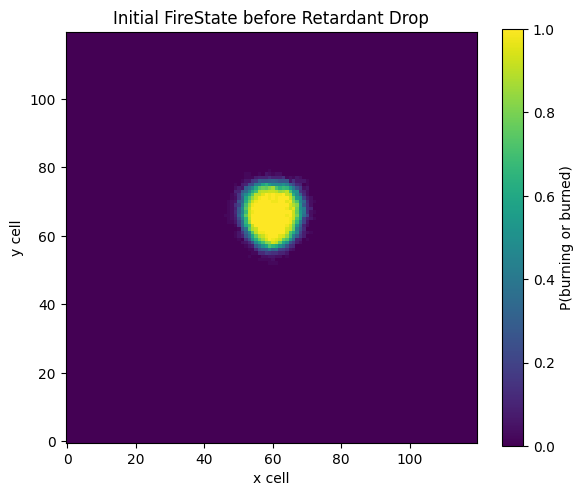

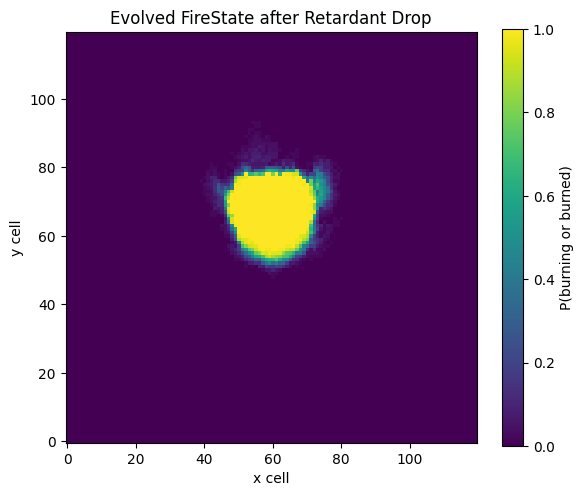

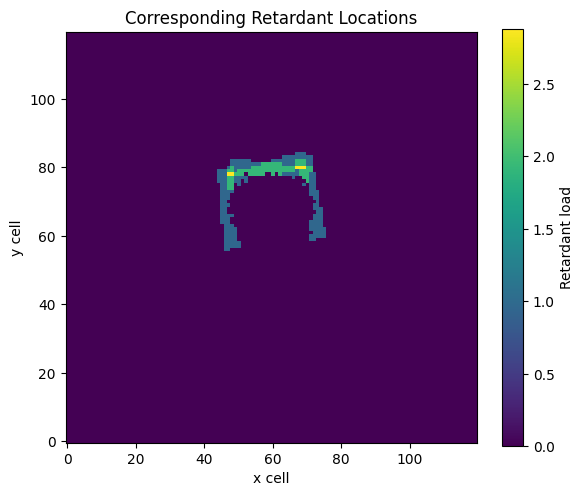

In [11]:
drop_opt.plot_evolved_firestate(
    theta=best_theta,
    n_sims=50,)